# Importing the Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec
import seaborn as sns
import warnings
%matplotlib inline
sns.set(style='ticks', font_scale=1.2)

warnings.filterwarnings('ignore')

# UDFs

In [2]:
def conti_var_summary(x):
    '''
    UDF for getting customised summary for continuous variables
    '''
    # freq and missings
    n_total = x.shape[0]
    n_miss = x.isna().sum()
    perc_miss = n_miss * 100 / n_total

    # outliers - iqr
    q1 = x.quantile(0.25)
    q3 = x.quantile(0.75)
    iqr = q3 - q1
    lc_iqr = q1 - 1.5 * iqr
    uc_iqr = q3 + 1.5 * iqr

    return pd.Series([
        x.dtype,
        x.nunique(), n_total,
        x.count(), n_miss, perc_miss,
        x.sum(),
        x.mean(),
        x.std(),
        x.var(), lc_iqr, uc_iqr,
        x.min(),
        x.quantile(0.01),
        x.quantile(0.05),
        x.quantile(0.10),
        x.quantile(0.25),
        x.quantile(0.5),
        x.quantile(0.75),
        x.quantile(0.90),
        x.quantile(0.95),
        x.quantile(0.99),
        x.max()
    ],
        index=[
        'dtype', 'cardinality', 'n_tot', 'n', 'nmiss',
        'perc_miss', 'sum', 'mean', 'std', 'var', 'lc_iqr',
        'uc_iqr', 'min', 'p1', 'p5', 'p10', 'p25', 'p50',
                         'p75', 'p90', 'p95', 'p99', 'max'
    ])

In [3]:
def cat_var_summary(x):
    '''
    UDF for getting customised summary for categorical variables
    '''
    Mode = x.value_counts().sort_values(ascending=False)[0:1].reset_index()
    return pd.Series([
        x.count(),
        x.nunique(),
        x.isnull().sum(), Mode.iloc[0, 0], Mode.iloc[0, 1],
        round(Mode.iloc[0, 1] * 100 / x.count(), 2)
    ],
                     index=['N', 'CARDINALITY', 'NMISS', 'MODE', 'FREQ', 'PERCENT'])

# Importing Data

In [4]:
cars = pd.read_excel('Car_Sales.xlsx')

### Data Inspection

In [5]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9576 entries, 0 to 9575
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   car           9576 non-null   object 
 1   price         9576 non-null   float64
 2   body          9576 non-null   object 
 3   mileage       9576 non-null   int64  
 4   engV          9142 non-null   float64
 5   engType       9576 non-null   object 
 6   registration  9576 non-null   object 
 7   year          9576 non-null   int64  
 8   model         9576 non-null   object 
 9   drive         9065 non-null   object 
dtypes: float64(2), int64(2), object(6)
memory usage: 748.2+ KB


In [6]:
cars.head()

,car,price,body,mileage,engV,engType,registration,year,model,drive
0,Ford,15500.0,crossover,68,2.5,Gas,yes,2010,Kuga,full
1,Mercedes-Benz,20500.0,sedan,173,1.8,Gas,yes,2011,E-Class,rear
2,Mercedes-Benz,35000.0,other,135,5.5,Petrol,yes,2008,CL 550,rear
3,Mercedes-Benz,17800.0,van,162,1.8,Diesel,yes,2012,B 180,front
4,Mercedes-Benz,33000.0,vagon,91,NaN,Other,yes,2013,E-Class,NaN


In [7]:
cars.shape

(9576, 10)

### Dropping Duplicates

In [8]:
cars.drop_duplicates(inplace=True)
cars.shape

(9463, 10)

### Summary

#### Continuous variables :

In [9]:
cars.select_dtypes(['int64','float64']).apply(conti_var_summary)

,price,mileage,engV,year
dtype,float64,int64,float64,int64
cardinality,1353,442,117,56
n_tot,9463,9463,9463,9463
n,9463,9463,9029,9463
nmiss,0,0,434,0
perc_miss,0.0,0.0,4.586283,0.0
sum,144820416.73165,1324107,23849.6,18987754
mean,15303.858896,139.924654,2.641444,2006.525837
std,23057.384098,98.466036,5.963016,7.062584
var,531642961.464639,9695.56027,35.557565,49.880092


#### Categorical variables :

In [10]:
cars.select_dtypes(['object']).apply(cat_var_summary)

,car,body,engType,registration,model,drive
N,9463,9463,9463,9463,9463,8953
CARDINALITY,87,6,4,2,863,3
NMISS,0,0,0,0,0,510
MODE,Volkswagen,sedan,Petrol,yes,E-Class,front
FREQ,927,3622,4341,8902,192,5171
PERCENT,9.8,38.28,45.87,94.07,2.03,57.76


### Anomalies

In [11]:
# Dropping Prices <= 0
cars.drop(cars[cars.price <= 0].index, inplace=True)

# Fixing Mileage column
cars['mileage'].replace(0, np.nan, inplace = True)
cars['mileage'] = cars.groupby(['car', 'body', 'engType'])['mileage'].transform(lambda x: x.fillna(x.median()))

cars.shape

(9223, 10)

***Skipping the outlier treatment for now. It will be done in EDA section if required for the Analysis.***

### Missing Values

In [12]:
pd.DataFrame([cars.isnull().sum(), cars.isnull().sum() / cars.shape[0] * 100], index=['count', '%']).T

,count,%
car,0.0,0.000000
price,0.0,0.000000
body,0.0,0.000000
mileage,9.0,0.097582
engV,425.0,4.608045
engType,0.0,0.000000
registration,0.0,0.000000
year,0.0,0.000000
model,0.0,0.000000
drive,491.0,5.323647


Trearting the NaNs as : <br>
* Filling values
    1. `drive` - mode() <br>
    2. `endV` - median() based on `car`, `body`, `engType` and `drive` <br>
* Dropping Rows 
    - `mileage`, `engV` - Whatever left as NaNs


In [13]:
# Filling values
cars.drive.fillna(value=cars.drive.mode()[0], inplace=True)
cars['engV'] = cars.groupby(['car', 'body', 'engType', 'drive']).engV.transform(lambda x: x.fillna(x.median()))

In [14]:
# Dropping Rows
cars.dropna(inplace=True)
cars.shape

(9163, 10)

In [15]:
pd.DataFrame([cars.isnull().sum(), cars.isnull().sum() / cars.shape[0] * 100], index=['count', '%']).T

,count,%
car,0.0,0.0
price,0.0,0.0
body,0.0,0.0
mileage,0.0,0.0
engV,0.0,0.0
engType,0.0,0.0
registration,0.0,0.0
year,0.0,0.0
model,0.0,0.0
drive,0.0,0.0


### Correlation

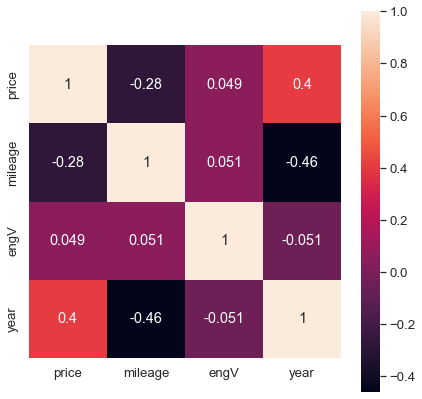

In [16]:
plt.figure(figsize=(7,7))
sns.set(font_scale=1.2)
sns.heatmap(cars.corr(), square=True, annot=True)
plt.show()

# EDA 

## 1. Which type of cars are sold maximum?

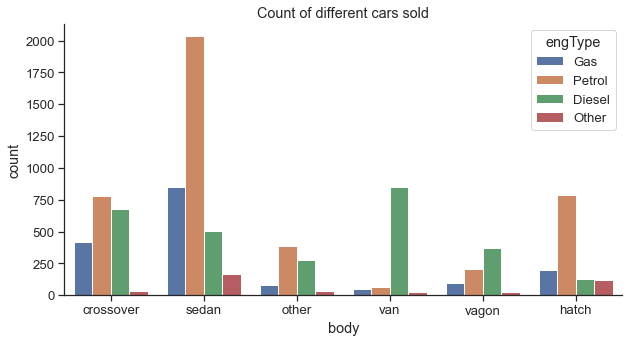

In [17]:
plt.figure(figsize=(10,5))
sns.set(style='ticks', font_scale=1.2)
sns.countplot(data=cars, x='body', hue='engType').set_title('Count of different cars sold')
sns.despine()
plt.show()

> Clearly **seadan - Petrol** cars are sold maximum.

## 2. What is the co-relation between price and mileage?

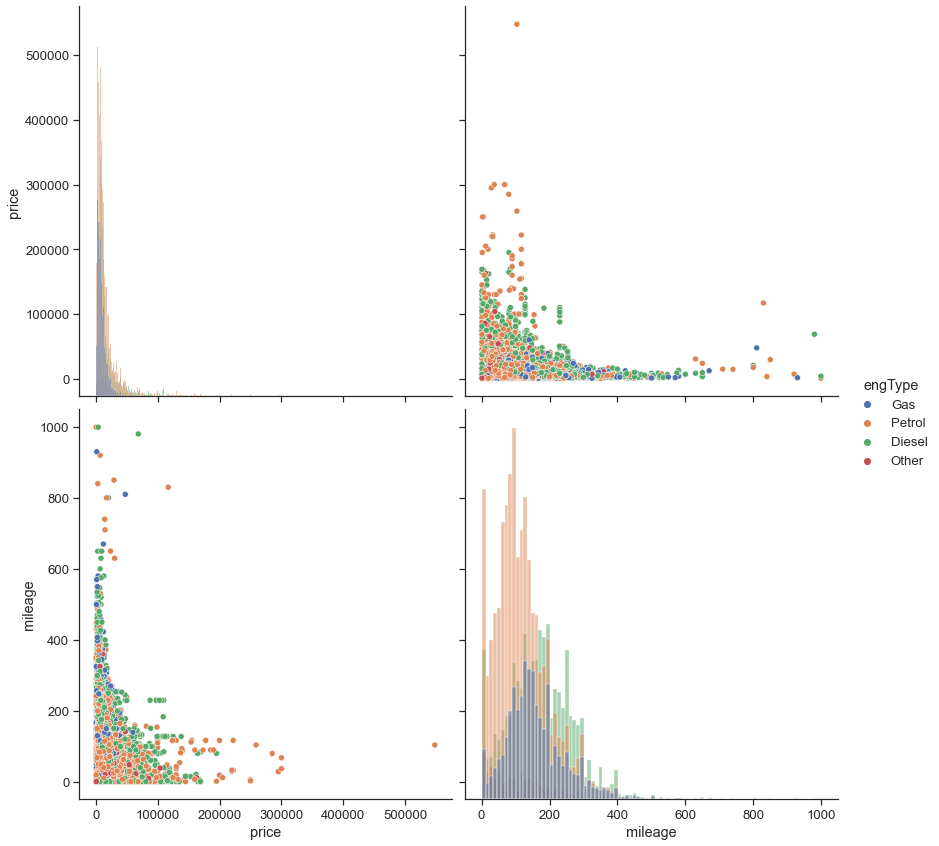

In [18]:
sns.set(style='ticks', font_scale=1.2)
sns.pairplot(cars.loc[:,['price','mileage','engType']], diag_kind='hist', hue='engType', height=6, aspect=1)
plt.show()

In [19]:
cars.loc[:,['price','mileage']].corr().iloc[1,0].round(2)

-0.28

> Price and Mileage are negatively co-related with corelation coefficient = -0.28 <br>
> From the pairplot above we can conclude that :
> - Most of the cars gives mileage in [1, 300] with price < 150000
> - There exists a few excpetions / outliers in case of Petrol cars.

## 3. How many cars are registered?

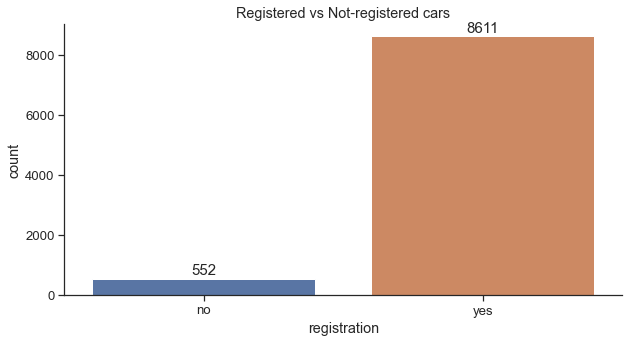

In [20]:
plt.figure(figsize=(10,5))
sns.set(style='ticks', font_scale=1.2)
plots = sns.barplot(x='registration', y='count', data=cars.groupby('registration').car.agg({'count'}).reset_index())
for bar in plots.patches:
    plots.annotate(str(format(bar.get_height(), '.0f')),
                   (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                   ha='center', va='center', size=15, xytext=(0, 8), textcoords='offset points')
plt.title('Registered vs Not-registered cars')
sns.despine()
plt.show()

> Total **8611** Cars are registered and **552** are not registered.

## 4. Price distribution between registered and non-registered cars.

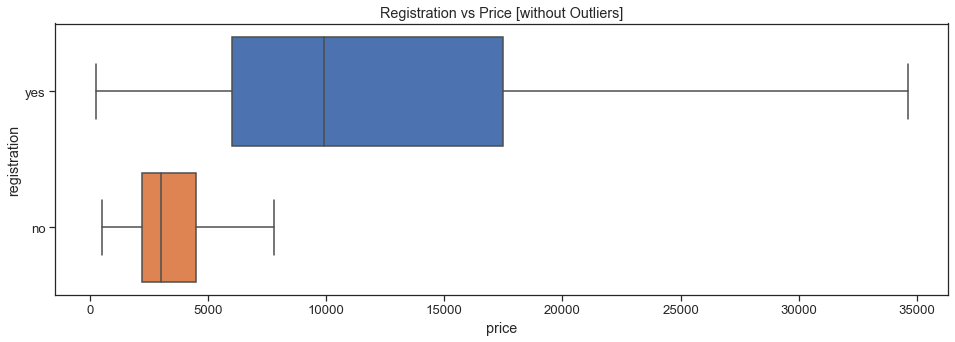

In [21]:
plt.figure(figsize=(16,5))
sns.set(style='ticks', font_scale=1.2)
sns.boxplot(x='price', y='registration', saturation=1, data=cars, showfliers=False) \
    .set_title('Registration vs Price [without Outliers]')
plt.show()

> Clearly we can say that all the cars which are registered have IQR of price between 6000 to 18000 with median at ~10000. And, cars which are not registered have price IQR between 2500 to 4500 with median around 3000. So, not-registered cars have significantly lower prices compared to the registered cars. 

## 5. What is the car price distribution based on Engine Value?

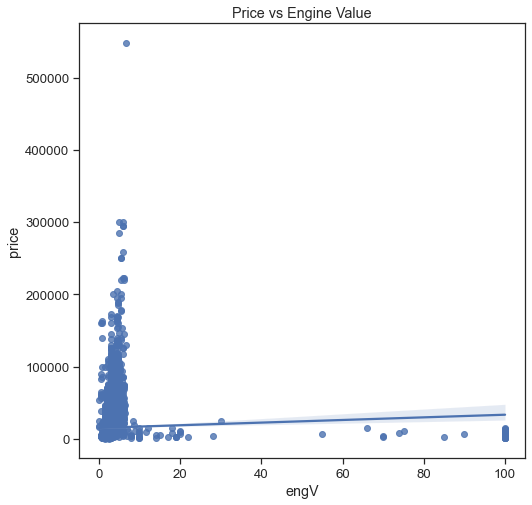

In [22]:
plt.figure(figsize=(8,8))
sns.set(style='ticks', font_scale=1.2)
sns.regplot(x='engV', y='price', data=cars, x_jitter=0, y_jitter=0).set_title('Price vs Engine Value')
plt.show()

In [23]:
cars.loc[:,['price','engV']].corr().iloc[1,0].round(2)

0.05

> Clearly This data contains outliers. So, we can better conclude the results after outlier treatement. As of now, the corr value between these two variables is 0.05.

In [24]:
cars1 = cars.loc[:,['price','engV']].apply(lambda x: x.clip(lower = x.quantile(0.01), upper = x.quantile(0.99)))

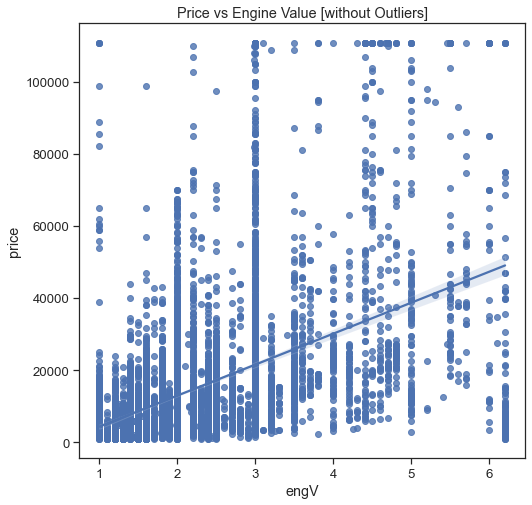

Updated Corr Value between Price and Engine Value : 0.48


In [25]:
plt.figure(figsize=(8,8))
sns.set(style='ticks', font_scale=1.2)
sns.regplot(x='engV', y='price', data=cars1, x_jitter=0, y_jitter=0).set_title('Price vs Engine Value [without Outliers]')
plt.show()
print('Updated Corr Value between Price and Engine Value :', cars1.loc[:,['price','engV']].corr().iloc[1,0].round(2))

> As per the observation, price range for most of the cars is in [0, 100000] with Engine Value in [1, 6] with a sighlty positiive trend in the data.

## 6. Which Engine Type of cars users preferred maximum?

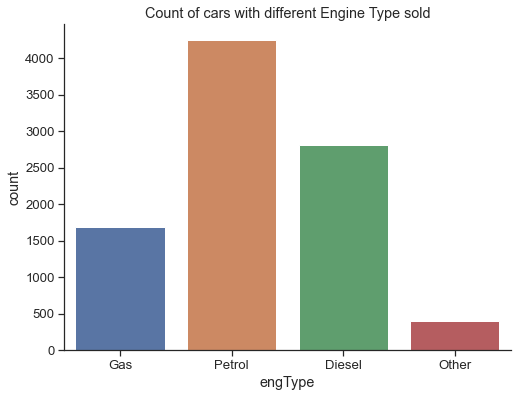

In [26]:
plt.figure(figsize=(8,6))
sns.set(style='ticks', font_scale=1.2)
sns.countplot(cars['engType']).set_title('Count of cars with different Engine Type sold')
sns.despine()
plt.show()

> Clearly, the user preference order is : Petrol > Diesel > Gas > Other

## 7. Establish corelation between all features using heatmap.

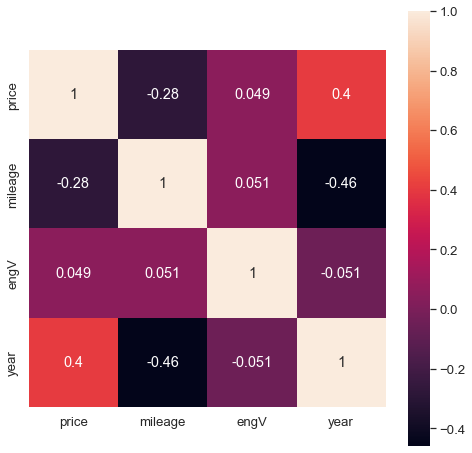

In [27]:
plt.figure(figsize=(8,8))
sns.set(font_scale=1.2)
sns.heatmap(cars.corr(), square=True, annot=True)
plt.show()

> * **Price** is positively co-related with **Engine Value** & **Year** and negatively co-related with **Mileage**.<br>
> * **Mileage** is positively co-related with **Engine Value** and negatively co-related with **Year**.<br>
> * **Engine Value**  is negatively co-related with **Year**.<br>
> * *None of the co-relation are strong. Here, Mileage and Year having the maximum co-relation with coefficient = -0.46.*

## 8. Distribution of Price

### Original Raw Data

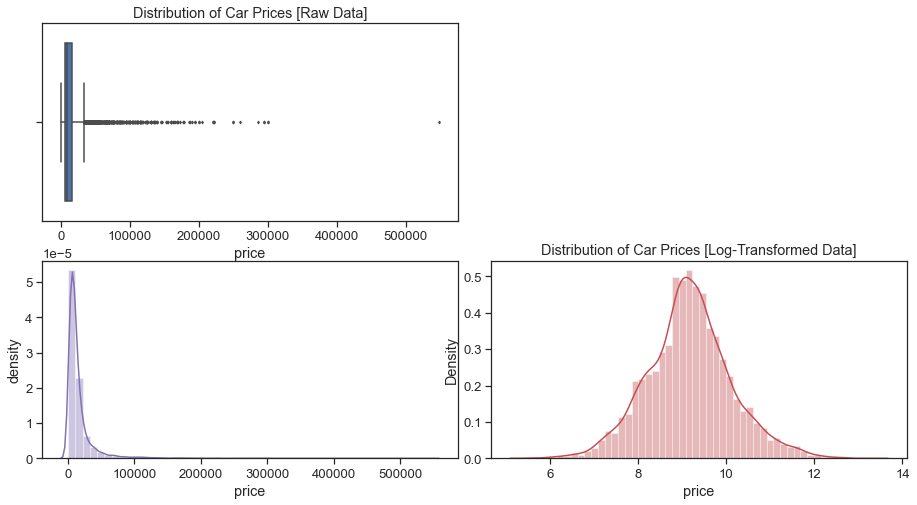

In [28]:
params = {'figure.figsize': (15.5, 8), 'axes.labelsize': 14}
plt.rcParams.update(params)
sns.set(style='ticks', font_scale=1.2)
gs = gridspec.GridSpec(2, 2, wspace=0.08)
f = pl.figure()

# Boxplot
ax = pl.subplot(gs[0, 0]) # row 0, col 0
sns.boxplot(x='price', saturation=1, data=cars, showfliers=True, ax=ax, fliersize=2) \
    .set_title('Distribution of Car Prices [Raw Data]')

ax = pl.subplot(gs[0, 1]) # row 0, col 1
ax.axis('off')

# Distplot
ax = pl.subplot(gs[1, 0]) # row 1, col 0
ax = sns.distplot(cars['price'],color ='m')
plt.ylabel('density')

# Logarithmic Distribution 
ax = pl.subplot(gs[1, 1]) # row 1, col 1
ax = sns.distplot(np.log(cars['price']),color ='r') \
    .set_title('Distribution of Car Prices [Log-Transformed Data]')

plt.show()

In [29]:
cars.price.skew()

6.127388141212242

> 1. We can see that this data contains lots of outliers. <br>
> 2. The price data is skewed towards left with skewness value = 6.127 <br>
> 3. Logarithmic distribution follows close to Normal distribution.

### After Outlier Treatment

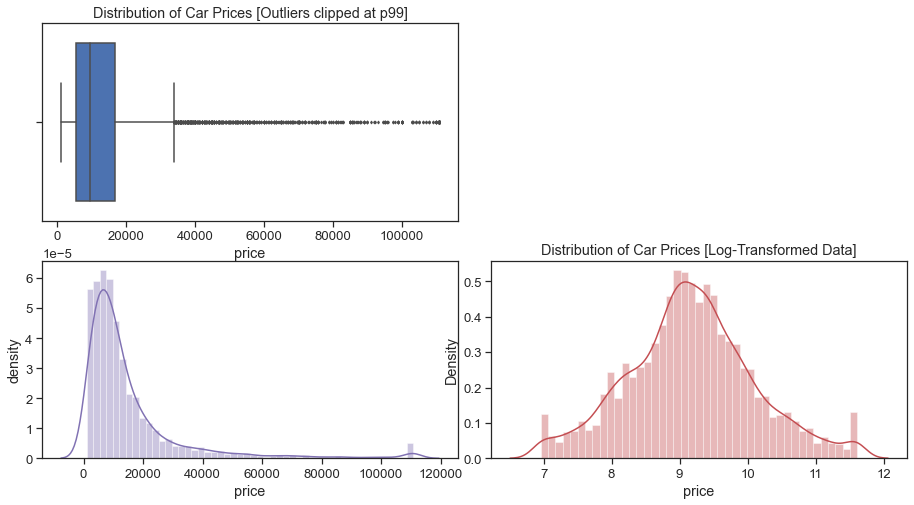

In [30]:
params = {'figure.figsize': (15.5, 8), 'axes.labelsize': 14}
plt.rcParams.update(params)
sns.set(style='ticks', font_scale=1.2)
gs = gridspec.GridSpec(2, 2, wspace=0.08)
f = pl.figure()

# Boxplot without Outliers (p99)
ax = pl.subplot(gs[0, 0]) # row 0, col 0
sns.boxplot(x='price', saturation=1, data=cars1, showfliers=True, ax=ax, fliersize=2) \
    .set_title('Distribution of Car Prices [Outliers clipped at p99]')

ax = pl.subplot(gs[0, 1]) # row 0, col 1
ax.axis('off')

# Distplot without Outliers (p99)
ax = pl.subplot(gs[1, 0]) # row 1, col 0
ax = sns.distplot(cars1['price'],color ='m')
plt.ylabel('density')

# Logarithmic Distribution without Outliers
ax = pl.subplot(gs[1, 1]) # row 1, col 1
ax = sns.distplot(np.log(cars1['price']),color ='r') \
    .set_title('Distribution of Car Prices [Log-Transformed Data]')

plt.show()

> After clipping the outliers at p99 value, we can see that - <br>
> 4. The Price Distribution has its IQR around [5000, 15000] range with median at 10000.<br>
> 5. Price varies from 0 to 40000 for maximum no. of instances.